In [1]:
import sys, glob, os
import pandas as pd
import numpy as np

In [ ]:
from download_time_series import download_amedas
opath = 'data_download/' 
point = '47646' # Tsukuba station
date_range = pd.date_range('2020-12-28', '2020-12-31', freq='d')
for date in date_range:
    dat, link = download_amedas(point, date, opath, 'hourly' )
    time.sleep(0.2)

# Assume we have downloaded AMeDAS data for Tsukuba station 
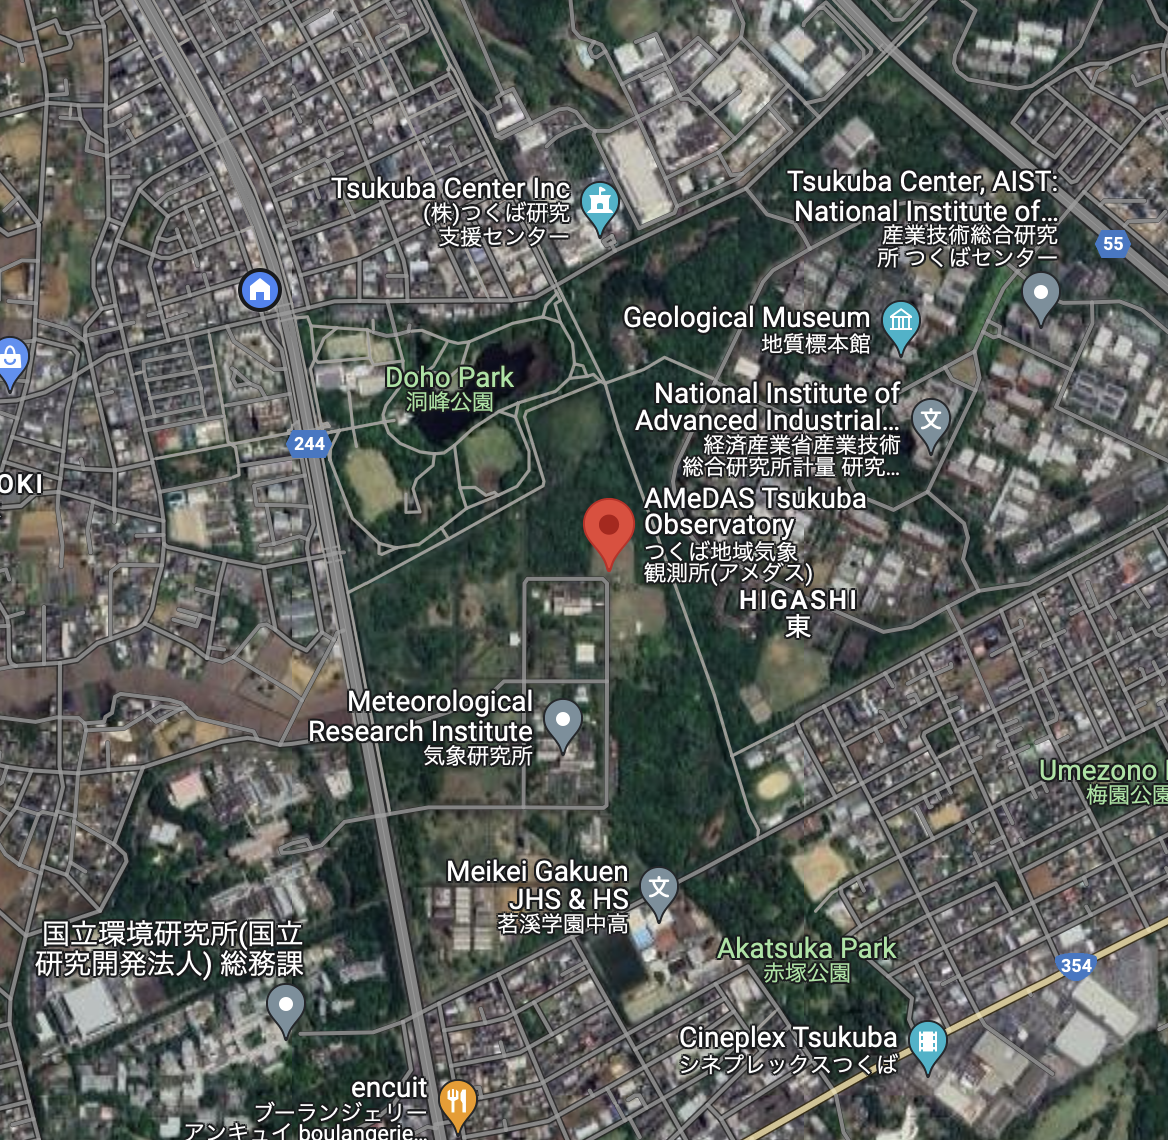
## Data is download in daily-basic: check data_download/
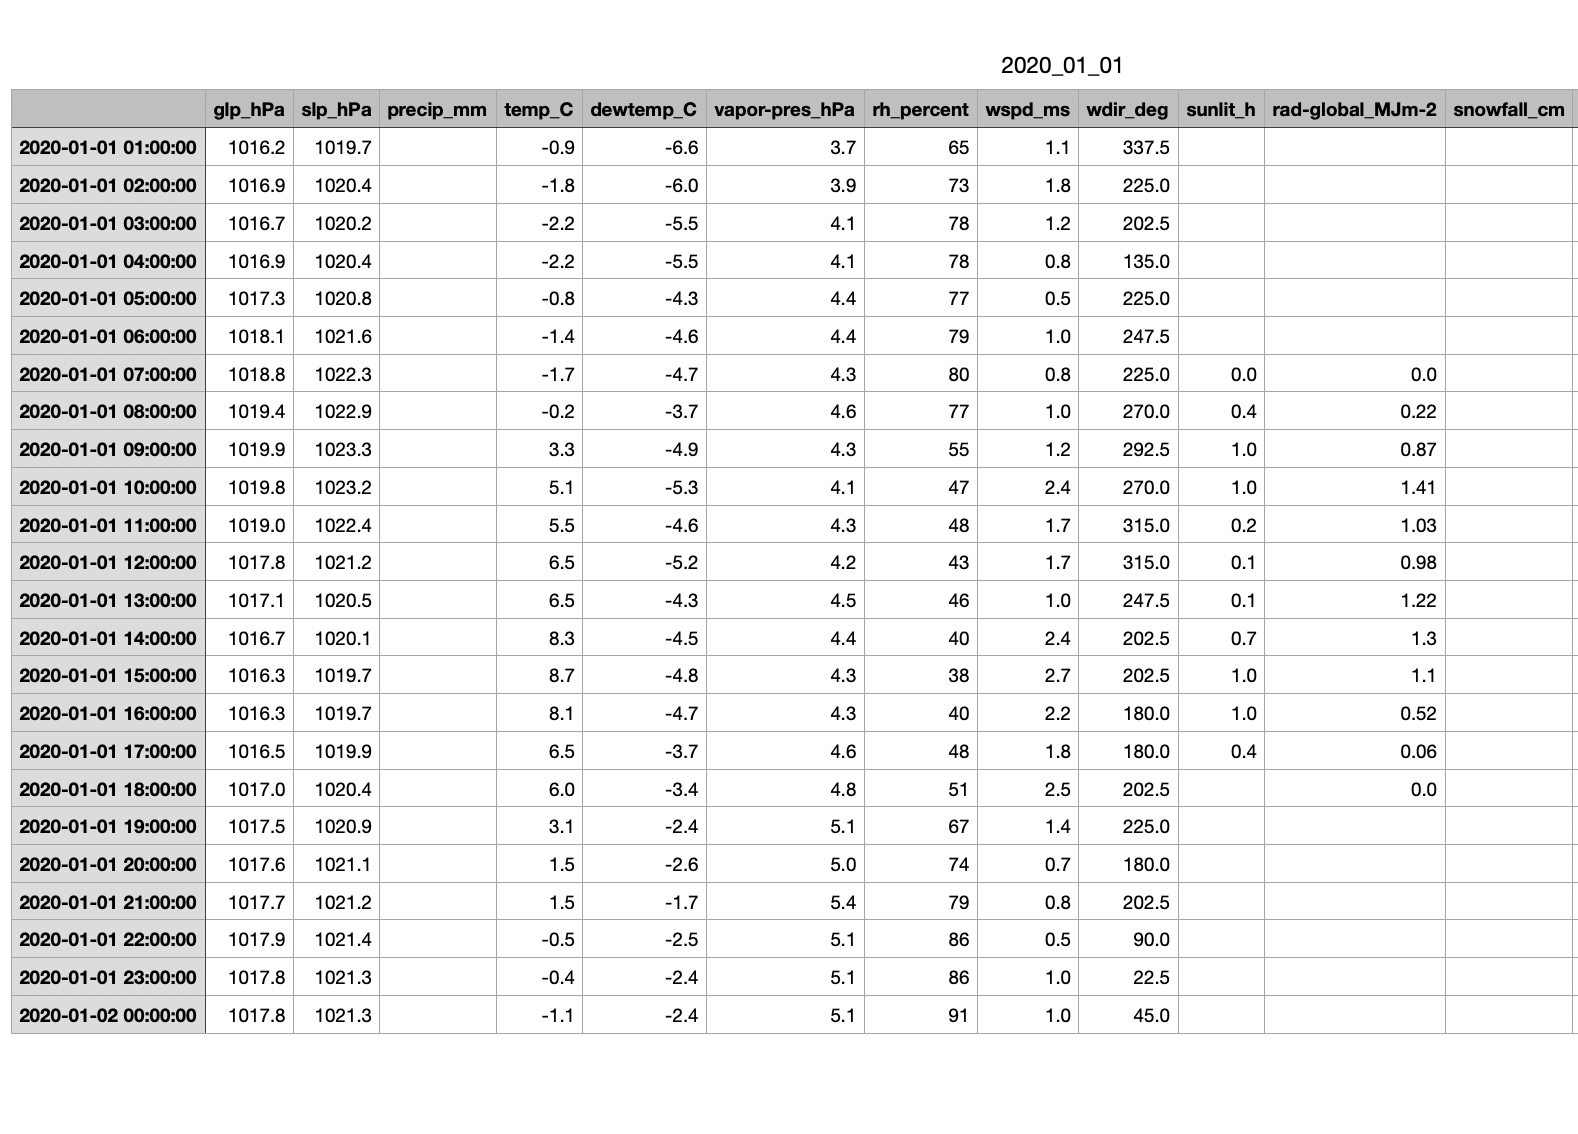
# First we combine all daily-basic file to one "all.csv" 

In [28]:
# list-up all files
point = '47646'
files = sorted(glob.glob('data_download/hourly/'+point+'/*'))
print(files[:5])
print(files[-5:])

['data_download/hourly/47646/1980_01_01.csv', 'data_download/hourly/47646/1980_01_02.csv', 'data_download/hourly/47646/1980_01_03.csv', 'data_download/hourly/47646/1980_01_04.csv', 'data_download/hourly/47646/1980_01_05.csv']
['data_download/hourly/47646/2020_12_27.csv', 'data_download/hourly/47646/2020_12_28.csv', 'data_download/hourly/47646/2020_12_29.csv', 'data_download/hourly/47646/2020_12_30.csv', 'data_download/hourly/47646/2020_12_31.csv']


In [29]:
# read each file, only get temperature and precipitation

dd = []
for f in files[:][:]:
    df = pd.read_csv(f, index_col=0, parse_dates=True)
    t = df[['temp_C', 'precip_mm' ] ]
    dd.append(t)

# concat all data, replace -999 to NaN 
do = pd.concat(dd).replace(-999,np.NaN) 

#
# save data output director (odir), 
# create this directory if not exist
odir = 'combined_hourly/'+point+'/'
if not os.path.isdir(odir): os.makedirs(odir)

ofile = odir + 'all.csv'

print(ofile)
do.to_csv(ofile)

combined_hourly/47646/all.csv


# Suppose that we have one file consist of hourly rainfall for station Tsukuba
# Now we want to generate IDF curves for such data

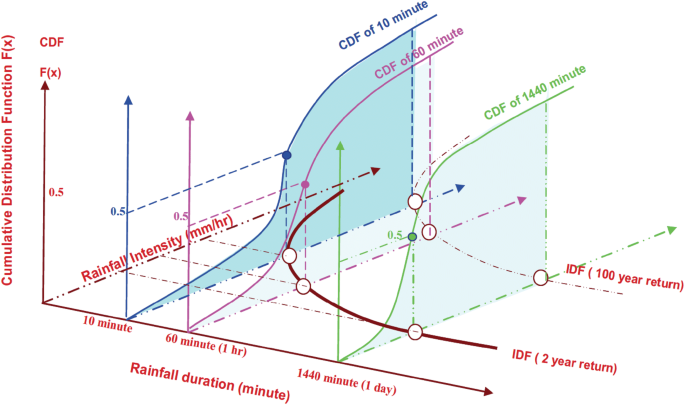


### Source: https://www.dpri.kyoto-u.ac.jp/nenpo/no49/49b0/a49b0p09.pdf


# There are three step to generate IDF curves

## 1. Create annual maxima

## 2. Define probability distrubtion fucntion that fit annual maxima data 

## 3. Define 


In [7]:
# Here we try to generate curves for durations: 1, 3, 6, 12, 24 hours
# And return years for 2, 5, 10, 30, 50, 100

duration = [1, 3, 6, 12, 24]
return_years = [2,5,10,30, 50,100]

In [17]:
#======
idir = 'combined_hourly/'+point+'/'
df = pd.read_csv(idir+'all.csv', index_col=0, parse_dates=True)['precip_mm']
df = df.replace(np.NaN, 0)

dd = {} # dictionary type 
#ms = []
for window in duration:
    print(window)  
    d1 = df.rolling(window, center=True).sum()[window-1::window]
    anmax = d1.groupby(d1.index.year).max()[:-1]
    dd[window] = { 'mean': anmax.mean(), 'std': anmax.std(), 'all': anmax}
    #ms.append( [anmax.mean(), anmax.std()] )

1
3
6
12
24


Text(0, 0.5, 'Precipitation intensity (mm)')

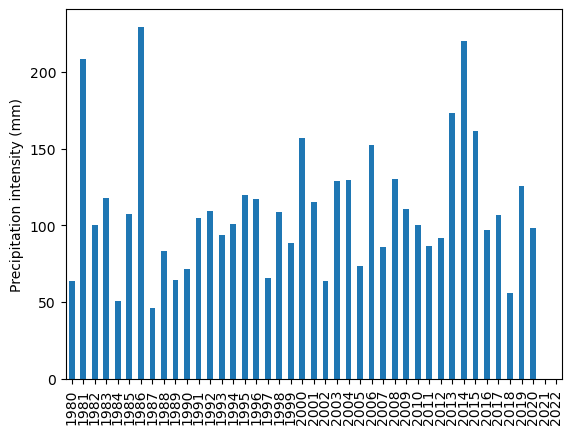

In [27]:
dat = dd[24]['all']
dat.plot(kind='bar')
plt.ylabel('Precipitation intensity (mm)')

<Axes: ylabel='Frequency'>

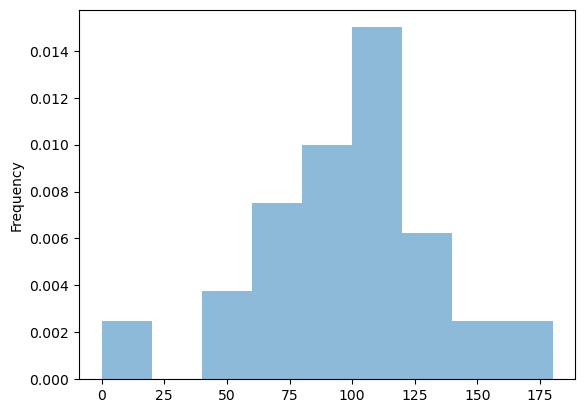

In [37]:
#dat.plot.hist(bins=np.arange(0,200,20), figsize=(10, 8))

dat.plot(kind='hist', density=1, bins=np.arange(0,200,20), stacked=False, alpha=.5)

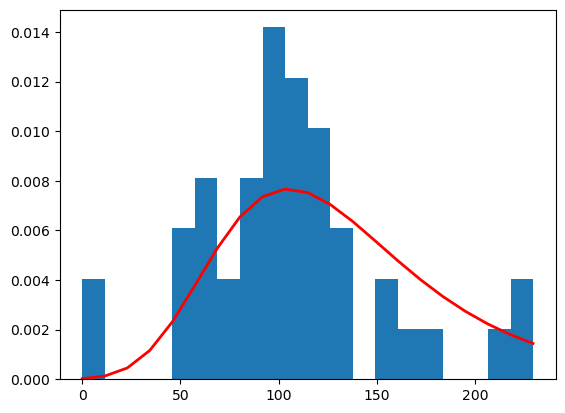

In [43]:
mu, beta = dat.mean(), dat.std() # location and scale
s = dat.values #np.random.gumbel(mu, beta, 1000)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 20, density=True)
plt.plot(bins, (1/beta)*np.exp(-(bins - mu)/beta)
         * np.exp( -np.exp( -(bins - mu) /beta) ),
         linewidth=2, color='r')
plt.show()



In [10]:
Kt= {}
for i in return_years:
    Kt[i] =  - np.sqrt(6)/np.pi*(0.5772+ np.log( np.log(i/(i-1)))) 


results = pd.DataFrame(index = duration, columns = return_years )

for return_y in return_years:
    for dur in duration:
        
        mu = dd[dur]['mean']
        sig = dd[dur]['std']
        k = Kt[return_y]
        
        x = ( mu + k * sig ) / dur
        
        results.loc[dur, return_y] = round(x,4)
print(results)

        2        5        10       30       50       100
1    30.629  41.3823  48.5019  59.2598  64.1709  70.7951
3   15.4224  21.4074  25.3699  31.3576   34.091  37.7778
6   10.5418  14.8732   17.741  22.0743  24.0525  26.7207
12   6.6322   9.6533  11.6535  14.6758  16.0556  17.9166
24   4.0482   5.8142   6.9834   8.7501   9.5567  10.6446


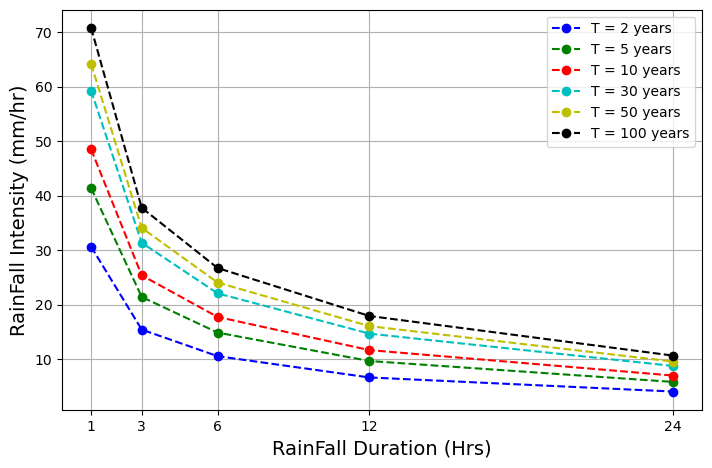

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = plt.axes([.1,.1,.8,.8])

for i, return_y in enumerate(results.columns):
    
    ax.plot(results.index,results.loc[:,return_y],linestyle='--', 
            marker='o', 
            color=['b', 'g', 'r', 'c', 'y','k'][i],
            label = 'T = '+str(return_y)+' years')

plt.ylabel('RainFall Intensity (mm/hr)', fontsize=14)
plt.xlabel('RainFall Duration (Hrs)', fontsize=14)
ax.set_xticks(duration)
ax.legend()
plt.grid()
plt.show()